## 0. Project Structure & Environment Initialization


This cell initializes a reproducible project directory structure used throughout the pipeline.


In [ ]:
!mkdir -p eth-walkforward-prediction/configs
!mkdir -p eth-walkforward-prediction/src/ethwf/pipelines
!mkdir -p eth-walkforward-prediction/experiments


"Project Configuration File (YAML)"

In [ ]:
%%writefile eth-walkforward-prediction/configs/config.yaml
project:
  name: "eth-walkforward-prediction"
  run_dir: "eth-walkforward-prediction/experiments"

data:
  symbol: "ETHUSDT"
  timeframe: "4h"
  timezone: "UTC"

target:
  horizon_candles: 6
  kind: "direction"

logging:
  level: "INFO"


Overwriting eth-walkforward-prediction/configs/config.yaml


In [ ]:
!pip install pyyaml pydantic


App Configuration & Validation Schema

In [ ]:
%%writefile eth-walkforward-prediction/src/ethwf/settings.py
from pathlib import Path
from typing import Literal
import yaml
from pydantic import BaseModel, Field

class ProjectCfg(BaseModel):
    name: str
    run_dir: str

class DataCfg(BaseModel):
    symbol: str
    timeframe: str
    timezone: str

class TargetCfg(BaseModel):
    horizon_candles: int = Field(ge=1)
    kind: Literal["direction", "return"]

class LoggingCfg(BaseModel):
    level: str

class AppConfig(BaseModel):
    project: ProjectCfg
    data: DataCfg
    target: TargetCfg
    logging: LoggingCfg

def load_config(path: str | Path) -> AppConfig:
    with open(path, "r") as f:
        raw = yaml.safe_load(f)
    return AppConfig.model_validate(raw)


Overwriting eth-walkforward-prediction/src/ethwf/settings.py


Custom Logging Configuration

In [ ]:
 %%writefile eth-walkforward-prediction/src/ethwf/logging_config.py
import logging

def setup_logging(level: str = "INFO"):
    logging.basicConfig(
        level=getattr(logging, level),
        format="%(asctime)s | %(levelname)s | %(name)s | %(message)s"
    )



Overwriting eth-walkforward-prediction/src/ethwf/logging_config.py


Pipeline Integration & Smoke Test Script

In [ ]:
%%writefile eth-walkforward-prediction/src/ethwf/pipelines/smoke_test.py
import sys
from pathlib import Path

# ✅ ADD PROJECT SRC TO PYTHON PATH (Colab-safe)
PROJECT_ROOT = Path(__file__).resolve().parents[2]
sys.path.append(str(PROJECT_ROOT))

import logging
from datetime import datetime, timezone

from ethwf.settings import load_config
from ethwf.logging_config import setup_logging

logger = logging.getLogger("ethwf.smoke")

def main():
    cfg = load_config("eth-walkforward-prediction/configs/config.yaml")
    setup_logging(cfg.logging.level)

    run_id = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S")
    run_dir = Path(cfg.project.run_dir) / run_id
    run_dir.mkdir(parents=True, exist_ok=True)

    logger.info("Project: %s", cfg.project.name)
    logger.info(
        "Symbol=%s timeframe=%s horizon=%s kind=%s",
        cfg.data.symbol,
        cfg.data.timeframe,
        cfg.target.horizon_candles,
        cfg.target.kind,
    )
    logger.info("Run directory created: %s", run_dir)
    logger.info("SMOKE TEST OK ✅")

if __name__ == "__main__":
    main()


Overwriting eth-walkforward-prediction/src/ethwf/pipelines/smoke_test.py


Python Path Configuration (System Setup)

In [ ]:
import sys
sys.path.append("/content/eth-walkforward-prediction/src")

print(sys.path[-1])


/content/eth-walkforward-prediction/src


Executing Smoke Test (Pipeline Verification)

In [ ]:
!python eth-walkforward-prediction/src/ethwf/pipelines/smoke_test.py


2026-02-06 13:16:46,148 | INFO | ethwf.smoke | Project: eth-walkforward-prediction
2026-02-06 13:16:46,149 | INFO | ethwf.smoke | Symbol=ETHUSDT timeframe=4h horizon=6 kind=direction
2026-02-06 13:16:46,149 | INFO | ethwf.smoke | Run directory created: eth-walkforward-prediction/experiments/20260206_131646
2026-02-06 13:16:46,149 | INFO | ethwf.smoke | SMOKE TEST OK ✅


Dependency Installation & Ingest Module Setup

In [ ]:
!pip -q install ccxt pandas pyarrow



In [ ]:
!mkdir -p eth-walkforward-prediction/src/ethwf/data


In [ ]:
%%writefile eth-walkforward-prediction/src/ethwf/data/ingest.py
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
import pandas as pd


@dataclass(frozen=True)
class IngestResult:
    df: pd.DataFrame
    report: dict


def _normalize_freq(freq: str) -> str:
    # pandas recommends lowercase units like "h" instead of "H"
    return freq.replace("H", "h")


def load_ohlcv_csv(
    path: str | Path,
    *,
    tz: str = "UTC",
    expected_freq: str = "4h",
) -> IngestResult:
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"CSV not found: {path}")

    df = pd.read_csv(path)

    ts_col_candidates = ["timestamp", "open_time", "time", "date", "datetime"]
    ts_col = next((c for c in ts_col_candidates if c in df.columns), None)
    if ts_col is None:
        raise ValueError(f"No timestamp column found. Expected one of: {ts_col_candidates}")

    if pd.api.types.is_numeric_dtype(df[ts_col]):
        df["ts"] = pd.to_datetime(df[ts_col], unit="ms", utc=True)
    else:
        df["ts"] = pd.to_datetime(df[ts_col], utc=True, errors="coerce")

    bad_ts = int(df["ts"].isna().sum())
    df = df.dropna(subset=["ts"]).copy()

    df = df.sort_values("ts")
    before_dups = len(df)
    df = df.drop_duplicates(subset=["ts"], keep="last")
    dup_dropped = before_dups - len(df)

    required = ["open", "high", "low", "close", "volume"]
    missing_cols = [c for c in required if c not in df.columns]

    ts = df["ts"]
    freq = _normalize_freq(expected_freq)

    full_index = pd.date_range(start=ts.min(), end=ts.max(), freq=freq, tz="UTC")
    observed = pd.Index(ts.unique())
    missing = full_index.difference(observed)

    report = {
        "file": str(path),
        "rows_after_ts_parse": int(len(df)),
        "bad_timestamps_dropped": bad_ts,
        "duplicate_timestamps_dropped": int(dup_dropped),
        "missing_required_cols": missing_cols,
        "start_ts": str(ts.min()),
        "end_ts": str(ts.max()),
        "expected_freq": freq,
        "missing_candles_count": int(len(missing)),
        "missing_candles_examples": [str(x) for x in missing[:10]],
    }

    keep = ["ts"] + [c for c in required if c in df.columns]
    df = df[keep].copy()

    return IngestResult(df=df, report=report)


Overwriting eth-walkforward-prediction/src/ethwf/data/ingest.py


Exchange Data Downloader (CCXT Fetcher Module)

In [ ]:
%%writefile eth-walkforward-prediction/src/ethwf/data/ccxt_fetch.py
from __future__ import annotations

from dataclasses import dataclass
from typing import List, Optional

import ccxt
import pandas as pd


@dataclass(frozen=True)
class FetchResult:
    df: pd.DataFrame
    meta: dict


def _to_ms(dt_str: str) -> int:
    return int(pd.Timestamp(dt_str, tz="UTC").timestamp() * 1000)


_TIMEFRAME_MS = {
    "1m": 60_000,
    "5m": 5 * 60_000,
    "15m": 15 * 60_000,
    "1h": 60 * 60_000,
    "4h": 4 * 60 * 60_000,
    "1d": 24 * 60 * 60_000,
}


def fetch_ohlcv_full_history(
    exchange_id: str,
    symbol: str,
    timeframe: str,
    start_date: str,
    limit: int = 300,
    sleep_ms: int = 250,
    max_calls: int = 20_000,
) -> FetchResult:
    """
    Robust CCXT OHLCV fetch with pagination + progress checks.

    Some exchanges return fewer than 'limit' even when more data exists,
    so we don't use len(batch) < limit as a hard stop.
    We stop when:
      - batch is empty, OR
      - timestamp does not advance, OR
      - we reach near "now"
    """
    tf_ms = _TIMEFRAME_MS.get(timeframe)
    if tf_ms is None:
        raise ValueError(f"Unsupported timeframe for tf_ms mapping: {timeframe}")

    exchange_cls = getattr(ccxt, exchange_id, None)
    if exchange_cls is None:
        raise ValueError(f"Unknown exchange_id: {exchange_id}")

    exchange = exchange_cls({"enableRateLimit": True})
    exchange.load_markets()

    if not exchange.has.get("fetchOHLCV", False):
        raise ValueError(f"{exchange_id} does not support fetchOHLCV")

    since = _to_ms(start_date)
    now_ms = int(pd.Timestamp.utcnow().timestamp() * 1000)

    all_rows: List[list] = []
    n_calls = 0
    last_ts_seen: Optional[int] = None

    while True:
        n_calls += 1
        if n_calls > max_calls:
            raise RuntimeError("Too many API calls (max_calls). Pagination may be stuck.")

        batch = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
        if not batch:
            break

        # Ensure progress
        batch_last_ts = batch[-1][0]
        if last_ts_seen is not None and batch_last_ts <= last_ts_seen:
            # No forward progress => stop
            break
        last_ts_seen = batch_last_ts

        all_rows.extend(batch)

        # Move forward exactly one candle to avoid repeating the last candle
        since = batch_last_ts + tf_ms

        # Stop if we have reached close to "now"
        if since >= now_ms - tf_ms:
            break

        exchange.sleep(sleep_ms)

    df = pd.DataFrame(all_rows, columns=["open_time", "open", "high", "low", "close", "volume"])
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms", utc=True)

    for c in ["open", "high", "low", "close", "volume"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["open_time", "open", "high", "low", "close", "volume"]).copy()
    df = df.sort_values("open_time").drop_duplicates(subset=["open_time"], keep="last").reset_index(drop=True)

    meta = {
        "exchange_id": exchange_id,
        "symbol": symbol,
        "timeframe": timeframe,
        "start_date": start_date,
        "rows": int(len(df)),
        "calls": int(n_calls),
        "start_ts": str(df["open_time"].min()) if len(df) else None,
        "end_ts": str(df["open_time"].max()) if len(df) else None,
        "limit": limit,
    }
    return FetchResult(df=df, meta=meta)


Overwriting eth-walkforward-prediction/src/ethwf/data/ccxt_fetch.py


Historical Data Retrieval (CCXT Data Fetching Test)

In [ ]:
import sys, json
sys.path.append("/content/eth-walkforward-prediction/src")

from ethwf.data.ccxt_fetch import fetch_ohlcv_full_history

res = fetch_ohlcv_full_history(
    exchange_id="kraken",
    symbol="ETH/USD",
    timeframe="4h",
    start_date="2019-01-01",
)

print(json.dumps(res.meta, indent=2))
display(res.df.head())
display(res.df.tail())
print("Shape:", res.df.shape)


{
  "exchange_id": "kraken",
  "symbol": "ETH/USD",
  "timeframe": "4h",
  "start_date": "2019-01-01",
  "rows": 721,
  "calls": 1,
  "start_ts": "2025-10-09 12:00:00+00:00",
  "end_ts": "2026-02-06 12:00:00+00:00"
}


,open_time,open,high,low,close,volume
0,2025-10-09 12:00:00+00:00,4376.66,4414.04,4295.00,4317.39,6878.985142
1,2025-10-09 16:00:00+00:00,4317.40,4345.00,4269.20,4340.82,8482.133854
2,2025-10-09 20:00:00+00:00,4340.49,4385.59,4331.71,4370.28,4583.431724
3,2025-10-10 00:00:00+00:00,4370.28,4395.00,4346.04,4351.37,1918.060540
4,2025-10-10 04:00:00+00:00,4351.38,4377.12,4316.40,4321.61,3105.717019


,open_time,open,high,low,close,volume
716,2026-02-05 20:00:00+00:00,1924.56,1938.65,1812.68,1823.85,30710.220597
717,2026-02-06 00:00:00+00:00,1823.49,1945.49,1744.56,1889.61,20837.288811
718,2026-02-06 04:00:00+00:00,1889.96,1972.40,1884.15,1897.38,8877.281140
719,2026-02-06 08:00:00+00:00,1897.23,1935.92,1862.52,1930.77,11440.833620
720,2026-02-06 12:00:00+00:00,1929.89,1941.78,1912.73,1936.38,2343.933410


Shape: (721, 6)


Filtering Tradable Asset Pairs (OKX Exchange Market Scan)

In [ ]:
import ccxt

ex = ccxt.okx({"enableRateLimit": True})
markets = ex.load_markets()

# ETH pairs filter
eth_pairs = [s for s in markets.keys() if s.startswith("ETH/")]
eth_pairs[:30], len(eth_pairs)


(['ETH/AUD',
  'ETH/AED',
  'ETH/BRL',
  'ETH/EUR',
  'ETH/TRY',
  'ETH/USD',
  'ETH/USDT',
  'ETH/USDC',
  'ETH/BTC',
  'ETH/USD:ETH-260213',
  'ETH/USD:ETH-260220',
  'ETH/USD:ETH-260227',
  'ETH/USD:ETH-260327',
  'ETH/USD:ETH-260626',
  'ETH/USD:ETH-260925',
  'ETH/USDT:USDT-260327',
  'ETH/USDT:USDT-260626',
  'ETH/USD:ETH',
  'ETH/USD:USD',
  'ETH/USDT:USDT',
  'ETH/USD:ETH-260207-1300-C',
  'ETH/USD:ETH-260207-1300-P',
  'ETH/USD:ETH-260207-1400-C',
  'ETH/USD:ETH-260207-1400-P',
  'ETH/USD:ETH-260207-1500-C',
  'ETH/USD:ETH-260207-1500-P',
  'ETH/USD:ETH-260207-1600-C',
  'ETH/USD:ETH-260207-1600-P',
  'ETH/USD:ETH-260207-1700-C',
  'ETH/USD:ETH-260207-1700-P'],
 806)

Multi-Batch Data Extraction (Large-Scale Historical Fetching from OKX)

In [ ]:
import sys, json
sys.path.append("/content/eth-walkforward-prediction/src")

from ethwf.data.ccxt_fetch import fetch_ohlcv_full_history

res_okx = fetch_ohlcv_full_history(
    exchange_id="okx",
    symbol="ETH/USDT",
    timeframe="4h",
    start_date="2019-01-01",
    limit=300,
)

print(json.dumps(res_okx.meta, indent=2))
print("Shape:", res_okx.df.shape)
display(res_okx.df.head())
display(res_okx.df.tail())



{
  "exchange_id": "okx",
  "symbol": "ETH/USDT",
  "timeframe": "4h",
  "start_date": "2019-01-01",
  "rows": 15562,
  "calls": 52,
  "start_ts": "2019-01-01 00:00:00+00:00",
  "end_ts": "2026-02-06 12:00:00+00:00"
}
Shape: (15562, 6)


,open_time,open,high,low,close,volume
0,2019-01-01 00:00:00+00:00,131.37,132.21,130.00,131.36,28425.544243
1,2019-01-01 04:00:00+00:00,131.35,134.18,131.29,133.50,31441.518910
2,2019-01-01 08:00:00+00:00,133.56,135.21,133.31,133.77,37834.229061
3,2019-01-01 12:00:00+00:00,133.76,135.73,132.31,132.95,34696.340204
4,2019-01-01 16:00:00+00:00,132.94,135.67,130.90,135.37,24958.332088


,open_time,open,high,low,close,volume
15557,2026-02-05 20:00:00+00:00,1928.92,1942.89,1816.15,1826.71,212439.397836
15558,2026-02-06 00:00:00+00:00,1826.70,1947.98,1744.00,1892.10,220336.987781
15559,2026-02-06 04:00:00+00:00,1892.10,1975.91,1886.19,1899.90,80525.170013
15560,2026-02-06 08:00:00+00:00,1899.71,1939.83,1866.73,1933.20,70506.185728
15561,2026-02-06 12:00:00+00:00,1932.80,1944.19,1915.05,1935.60,12513.413470


In [ ]:
raw_path = "eth-walkforward-prediction/experiments/raw_okx_ethusdt_4h.parquet"
res_okx.df.to_parquet(raw_path, index=False)
print("✅ Saved raw:", raw_path)


✅ Saved raw: eth-walkforward-prediction/experiments/raw_okx_ethusdt_4h.parquet


Data Integrity Verification (End-to-End Ingestion Quality Check)

In [ ]:
import json
from ethwf.data.ingest import load_ohlcv_csv

tmp_csv = "/content/eth_okx_tmp.csv"
res_okx.df.to_csv(tmp_csv, index=False)

result = load_ohlcv_csv(tmp_csv, expected_freq="4H")

print("✅ Missing candles:", result.report["missing_candles_count"])
print(json.dumps(result.report, indent=2))


✅ Missing candles: 0
{
  "file": "/content/eth_okx_tmp.csv",
  "rows_raw": null,
  "rows_after_ts_parse": 15562,
  "bad_timestamps_dropped": 0,
  "duplicate_timestamps_dropped": 0,
  "missing_required_cols": [],
  "start_ts": "2019-01-01 00:00:00+00:00",
  "end_ts": "2026-02-06 12:00:00+00:00",
  "expected_freq": "4H",
  "missing_candles_count": 0,
  "missing_candles_examples": []
}


/content/eth-walkforward-prediction/src/ethwf/data/ingest.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=ts.min(), end=ts.max(), freq=expected_freq, tz="UTC")


Final Data Serialization (Optimized Parquet Storage)

In [ ]:
clean_path = "eth-walkforward-prediction/experiments/clean_eth_4h.parquet"
result.df.to_parquet(clean_path, index=False)
print("✅ Saved clean:", clean_path)

print("Clean shape:", result.df.shape)
display(result.df.head())
display(result.df.tail())


✅ Saved clean: eth-walkforward-prediction/experiments/clean_eth_4h.parquet
Clean shape: (15562, 6)


,ts,open,high,low,close,volume
0,2019-01-01 00:00:00+00:00,131.37,132.21,130.00,131.36,28425.544243
1,2019-01-01 04:00:00+00:00,131.35,134.18,131.29,133.50,31441.518910
2,2019-01-01 08:00:00+00:00,133.56,135.21,133.31,133.77,37834.229061
3,2019-01-01 12:00:00+00:00,133.76,135.73,132.31,132.95,34696.340204
4,2019-01-01 16:00:00+00:00,132.94,135.67,130.90,135.37,24958.332088


,ts,open,high,low,close,volume
15557,2026-02-05 20:00:00+00:00,1928.92,1942.89,1816.15,1826.71,212439.397836
15558,2026-02-06 00:00:00+00:00,1826.70,1947.98,1744.00,1892.10,220336.987781
15559,2026-02-06 04:00:00+00:00,1892.10,1975.91,1886.19,1899.90,80525.170013
15560,2026-02-06 08:00:00+00:00,1899.71,1939.83,1866.73,1933.20,70506.185728
15561,2026-02-06 12:00:00+00:00,1932.80,1944.19,1915.05,1935.60,12513.413470


In [ ]:
report_path = "eth-walkforward-prediction/experiments/ingestion_report_eth_4h.json"
with open(report_path, "w", encoding="utf-8") as f:
    json.dump(result.report, f, indent=2)

print("✅ Saved report:", report_path)


✅ Saved report: eth-walkforward-prediction/experiments/ingestion_report_eth_4h.json


Feature Engineering Module Initialization

In [ ]:
!mkdir -p eth-walkforward-prediction/src/ethwf/features


Feature Construction Pipeline (Core Feature Engineering)

In [ ]:
%%writefile eth-walkforward-prediction/src/ethwf/features/build.py
from __future__ import annotations

import numpy as np
import pandas as pd


def build_features_and_target(
    df: pd.DataFrame,
    *,
    horizon_candles: int = 6,
    target_kind: str = "direction",
) -> pd.DataFrame:
    d = df.copy().sort_values("ts").reset_index(drop=True)

    # ✅ HARD FORCE: make sure numeric cols are pure float64 (no <NA>, no object)
    num_cols = ["open", "high", "low", "close", "volume"]
    for c in num_cols:
        d[c] = pd.to_numeric(d[c], errors="coerce")      # strings/objects -> numbers or NaN
        d[c] = d[c].astype("float64")                    # force numpy float64

    # ✅ Return (float64)
    d["ret_1"] = d["close"].pct_change().astype("float64")

    # --- Lags (past-only) ---
    for lag in [1, 2, 3, 6, 12, 18]:
        d[f"ret_lag{lag}"] = d["ret_1"].shift(lag).astype("float64")

    # --- Rolling stats (past-only) ---
    # IMPORTANT: ensure ret_1 is numeric BEFORE rolling
    d["ret_1"] = pd.to_numeric(d["ret_1"], errors="coerce").astype("float64")

    for win in [6, 18, 42]:
        r = d["ret_1"].rolling(window=win, min_periods=win)
        d[f"ret_mean_{win}"] = r.mean().astype("float64")
        d[f"ret_std_{win}"] = r.std().astype("float64")

    # --- Volume features ---
    d["vol_chg_1"] = d["volume"].pct_change().astype("float64")

    d["volume"] = pd.to_numeric(d["volume"], errors="coerce").astype("float64")
    for win in [6, 18, 42]:
        v = d["volume"].rolling(window=win, min_periods=win)
        d[f"vol_mean_{win}"] = v.mean().astype("float64")
        d[f"vol_std_{win}"] = v.std().astype("float64")

    # --- Range feature ---
    d["hl_range"] = ((d["high"] - d["low"]) / d["close"]).astype("float64")

    # --- Target (future) ---
    future_close = d["close"].shift(-horizon_candles)

    if target_kind == "direction":
        d["y"] = (future_close > d["close"]).astype("int64")
    elif target_kind == "return":
        d["y"] = (future_close / d["close"] - 1.0).astype("float64")
    else:
        raise ValueError("target_kind must be 'direction' or 'return'")

    # ✅ Drop NaNs (rolling + shifts create NaNs at start/end)
    feature_cols = [c for c in d.columns if c not in ["ts", "y"]]
    d = d.dropna(subset=["y"] + feature_cols).copy()

    # ✅ Final safety check (must be all numeric except ts)
    bad = d.drop(columns=["ts"]).select_dtypes(include=["object"]).columns.tolist()
    if bad:
        raise TypeError(f"Found object dtype columns after feature build: {bad}")

    return d




Overwriting eth-walkforward-prediction/src/ethwf/features/build.py


Hot-Reloading Feature Module (Development Workflow Setup)

In [ ]:
import sys, importlib
sys.path.append("/content/eth-walkforward-prediction/src")

import ethwf.features.build as build_mod
importlib.reload(build_mod)

print("Reloaded build.py from:", build_mod.__file__)


Reloaded build.py from: /content/eth-walkforward-prediction/src/ethwf/features/build.py


Feature and Target Generation (Final Model Input Test)

In [ ]:
import pandas as pd

df = pd.read_parquet("eth-walkforward-prediction/experiments/clean_eth_4h.parquet")

feat = build_mod.build_features_and_target(df, horizon_candles=6, target_kind="direction")

print("Feature df shape:", feat.shape)
print("y mean:", float(feat["y"].mean()))
print("Any object cols?:", feat.select_dtypes(include=["object"]).columns.tolist())
display(feat.head())


Feature df shape: (15516, 28)
y mean: 0.5191415313225058
Any object cols?: []


,ts,open,high,low,close,volume,ret_1,ret_lag1,ret_lag2,ret_lag3,...,ret_std_42,vol_chg_1,vol_mean_6,vol_std_6,vol_mean_18,vol_std_18,vol_mean_42,vol_std_42,hl_range,y
42,2019-01-08 00:00:00+00:00,149.39,150.64,145.28,146.64,50504.748597,-0.018342,-0.013016,0.005247,-0.004891,...,0.017683,0.824730,37578.368905,13301.330373,49045.592212,17286.908977,54198.631910,22705.100916,0.036552,1
43,2019-01-08 04:00:00+00:00,146.57,147.44,145.99,146.77,39212.921907,0.000887,-0.018342,-0.013016,0.005247,...,0.017555,-0.223580,40123.302536,11511.073221,47293.993894,16540.445455,54383.665315,22546.230692,0.009879,1
44,2019-01-08 08:00:00+00:00,146.79,150.17,146.44,149.60,44560.136378,0.019282,0.000887,-0.018342,-0.013016,...,0.017746,0.136364,37992.697927,8466.739371,46970.804507,16533.483445,54543.805965,22449.495645,0.024933,0
45,2019-01-08 12:00:00+00:00,149.66,151.50,148.50,148.82,60235.113592,-0.005214,0.019282,0.000887,-0.018342,...,0.017736,0.351771,42413.243425,11979.819348,46685.152512,16238.559643,55151.871998,22243.724173,0.020159,0
46,2019-01-08 16:00:00+00:00,148.82,149.15,147.36,148.13,32162.634648,-0.004636,-0.005214,0.019282,0.000887,...,0.017603,-0.466048,42392.247944,12001.203619,45182.134074,16262.439457,55323.403011,22031.979689,0.012084,1


Validation Strategy Infrastructure (Splits Module Setup)

In [ ]:
!mkdir -p eth-walkforward-prediction/src/ethwf/splits


In [ ]:
%%writefile eth-walkforward-prediction/src/ethwf/splits/walkforward.py
from __future__ import annotations

from dataclasses import dataclass
import pandas as pd


@dataclass(frozen=True)
class Fold:
    fold_id: int
    train_start: pd.Timestamp
    train_end: pd.Timestamp
    test_start: pd.Timestamp
    test_end: pd.Timestamp


def make_walkforward_folds(
    ts: pd.Series,
    *,
    train_days: int = 365 * 2,
    test_days: int = 30,
    step_days: int = 30,
) -> list[Fold]:
    """
    Rolling walk-forward folds based on timestamps.

    - Train window: [test_start - train_days, test_start)
    - Test window : [test_start, test_start + test_days]
    - Next fold shifts by step_days
    """
    tmin = pd.to_datetime(ts.min(), utc=True)
    tmax = pd.to_datetime(ts.max(), utc=True)

    folds: list[Fold] = []
    fold_id = 0

    test_start = tmin + pd.Timedelta(days=train_days)
    while True:
        train_start = test_start - pd.Timedelta(days=train_days)
        train_end = test_start - pd.Timedelta(seconds=1)

        test_end = test_start + pd.Timedelta(days=test_days) - pd.Timedelta(seconds=1)

        if test_end > tmax:
            break

        folds.append(
            Fold(
                fold_id=fold_id,
                train_start=train_start,
                train_end=train_end,
                test_start=test_start,
                test_end=test_end,
            )
        )

        fold_id += 1
        test_start = test_start + pd.Timedelta(days=step_days)

    return folds


Overwriting eth-walkforward-prediction/src/ethwf/splits/walkforward.py


Modeling and Evaluation Framework Setup

In [ ]:
!mkdir -p eth-walkforward-prediction/src/ethwf/models
!mkdir -p eth-walkforward-prediction/src/ethwf/evaluation


In [ ]:
%%writefile eth-walkforward-prediction/src/ethwf/models/baseline.py
from __future__ import annotations

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


def make_baseline_classifier(random_state: int = 42) -> Pipeline:
    """
    Baseline: Standardize numeric features + Logistic Regression.
    """
    return Pipeline(
        steps=[
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("clf", LogisticRegression(max_iter=2000, random_state=random_state)),
        ]
    )


Overwriting eth-walkforward-prediction/src/ethwf/models/baseline.py


In [ ]:
%%writefile eth-walkforward-prediction/src/ethwf/evaluation/metrics.py
from __future__ import annotations

import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score


def classification_metrics(y_true, y_prob) -> dict:
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    y_pred = (y_prob >= 0.5).astype(int)

    out = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }
    # AUC requires both classes present
    if len(set(y_true.tolist())) == 2:
        out["auc"] = float(roc_auc_score(y_true, y_prob))
    else:
        out["auc"] = float("nan")
    return out


Overwriting eth-walkforward-prediction/src/ethwf/evaluation/metrics.py


In [ ]:
%%writefile eth-walkforward-prediction/src/ethwf/pipelines/run_walkforward_baseline.py
from __future__ import annotations

import sys
from pathlib import Path

# ✅ Colab-safe import path
PROJECT_SRC = Path(__file__).resolve().parents[2]
sys.path.append(str(PROJECT_SRC))

import numpy as np
import pandas as pd

from ethwf.splits.walkforward import make_walkforward_folds
from ethwf.models.baseline import make_baseline_classifier
from ethwf.evaluation.metrics import classification_metrics


def _sanitize_xy(X: pd.DataFrame, y: pd.Series) -> tuple[pd.DataFrame, pd.Series, dict]:
    """
    Replace inf with NaN and drop rows with any NaN.
    Returns cleaned X,y and a small report.
    """
    X2 = X.replace([np.inf, -np.inf], np.nan)
    mask = ~X2.isna().any(axis=1)
    dropped = int((~mask).sum())
    return X2.loc[mask], y.loc[mask], {"dropped_rows": dropped}


def main() -> None:
    feat_path = "eth-walkforward-prediction/experiments/features_eth_4h.parquet"
    if not Path(feat_path).exists():
        raise FileNotFoundError(f"Missing features file: {feat_path}. Save features first.")

    df = pd.read_parquet(feat_path).sort_values("ts").reset_index(drop=True)
    feature_cols = [c for c in df.columns if c not in ["ts", "y"]]

    folds = make_walkforward_folds(df["ts"], train_days=365*2, test_days=30, step_days=30)
    print("Num folds:", len(folds))

    all_rows = []
    for fold in folds:
        train_mask = (df["ts"] >= fold.train_start) & (df["ts"] <= fold.train_end)
        test_mask = (df["ts"] >= fold.test_start) & (df["ts"] <= fold.test_end)

        train = df.loc[train_mask]
        test = df.loc[test_mask]

        X_train_df, y_train_s, rep_tr = _sanitize_xy(train[feature_cols], train["y"])
        X_test_df, y_test_s, rep_te = _sanitize_xy(test[feature_cols], test["y"])

        # If too few rows after cleaning, skip fold
        if len(X_train_df) < 2000 or len(X_test_df) < 50:
            print(f"Fold {fold.fold_id}: skipped (after clean n_train={len(X_train_df)}, n_test={len(X_test_df)})")
            continue

        model = make_baseline_classifier()
        model.fit(X_train_df.to_numpy(), y_train_s.to_numpy())

        y_prob = model.predict_proba(X_test_df.to_numpy())[:, 1]
        m = classification_metrics(y_test_s.to_numpy(), y_prob)

        row = {
            "fold_id": fold.fold_id,
            "train_start": str(fold.train_start),
            "train_end": str(fold.train_end),
            "test_start": str(fold.test_start),
            "test_end": str(fold.test_end),
            "n_train_raw": int(len(train)),
            "n_test_raw": int(len(test)),
            "n_train": int(len(X_train_df)),
            "n_test": int(len(X_test_df)),
            "train_dropped_inf_nan": rep_tr["dropped_rows"],
            "test_dropped_inf_nan": rep_te["dropped_rows"],
            **m,
        }
        all_rows.append(row)
        print(f"Fold {fold.fold_id}: {m} | dropped train={rep_tr['dropped_rows']} test={rep_te['dropped_rows']}")

    out_df = pd.DataFrame(all_rows)
    out_path = "eth-walkforward-prediction/experiments/walkforward_baseline_metrics.parquet"
    out_df.to_parquet(out_path, index=False)

    print("Saved metrics:", out_path)
    print("\nSummary:")
    print(out_df[["accuracy", "f1", "auc"]].describe())


if __name__ == "__main__":
    main()


Overwriting eth-walkforward-prediction/src/ethwf/pipelines/run_walkforward_baseline.py


In [ ]:
feat_path = "eth-walkforward-prediction/experiments/features_eth_4h.parquet"
feat.to_parquet(feat_path, index=False)
print("✅ Saved features:", feat_path)


✅ Saved features: eth-walkforward-prediction/experiments/features_eth_4h.parquet


Executing Walk-Forward Baseline (Strategy Backtesting & Training)

In [ ]:
!python eth-walkforward-prediction/src/ethwf/pipelines/run_walkforward_baseline.py



Num folds: 61
Fold 0: {'accuracy': 0.5833333333333334, 'f1': 0.734982332155477, 'auc': 0.4825396825396825} | dropped train=0 test=0
Fold 1: {'accuracy': 0.5611111111111111, 'f1': 0.7148014440433214, 'auc': 0.486903120691816} | dropped train=0 test=0
Fold 2: {'accuracy': 0.5666666666666667, 'f1': 0.7214285714285714, 'auc': 0.5267722473604827} | dropped train=0 test=0
Fold 3: {'accuracy': 0.6833333333333333, 'f1': 0.8080808080808081, 'auc': 0.4701090909090909} | dropped train=0 test=0
Fold 4: {'accuracy': 0.5111111111111111, 'f1': 0.6691729323308271, 'auc': 0.5595752562044698} | dropped train=0 test=0
Fold 5: {'accuracy': 0.5055555555555555, 'f1': 0.6482213438735178, 'auc': 0.491604938271605} | dropped train=0 test=0
Fold 6: {'accuracy': 0.5722222222222222, 'f1': 0.6932270916334662, 'auc': 0.5278856999624013} | dropped train=0 test=0
Fold 7: {'accuracy': 0.5222222222222223, 'f1': 0.6386554621848739, 'auc': 0.5131761442441054} | dropped train=0 test=0
Fold 8: {'accuracy': 0.49444444444444

Tree-Based Model Architecture

In [ ]:
%%writefile eth-walkforward-prediction/src/ethwf/models/tree.py
from __future__ import annotations

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier


def make_tree_classifier(random_state: int = 42) -> Pipeline:
    """
    Strong baseline for tabular time-series features.
    - Handles nonlinearity better than LogisticRegression.
    - Works well with noisy features.
    """
    return Pipeline(
        steps=[
            # even though we drop NaNs, imputer makes pipeline robust
            ("imputer", SimpleImputer(strategy="median")),
            ("clf", HistGradientBoostingClassifier(
                random_state=random_state,
                max_depth=4,
                learning_rate=0.05,
                max_iter=300,
            )),
        ]
    )


Overwriting eth-walkforward-prediction/src/ethwf/models/tree.py


In [ ]:
%%writefile eth-walkforward-prediction/src/ethwf/pipelines/run_walkforward_tree.py
from __future__ import annotations

import sys
from pathlib import Path

PROJECT_SRC = Path(__file__).resolve().parents[2]
sys.path.append(str(PROJECT_SRC))

import numpy as np
import pandas as pd

from ethwf.splits.walkforward import make_walkforward_folds
from ethwf.models.tree import make_tree_classifier
from ethwf.evaluation.metrics import classification_metrics


def _sanitize_xy(X: pd.DataFrame, y: pd.Series) -> tuple[pd.DataFrame, pd.Series]:
    X2 = X.replace([np.inf, -np.inf], np.nan)
    mask = ~X2.isna().any(axis=1)
    return X2.loc[mask], y.loc[mask]


def main() -> None:
    feat_path = "eth-walkforward-prediction/experiments/features_eth_4h.parquet"
    df = pd.read_parquet(feat_path).sort_values("ts").reset_index(drop=True)
    feature_cols = [c for c in df.columns if c not in ["ts", "y"]]

    folds = make_walkforward_folds(df["ts"], train_days=365*2, test_days=30, step_days=30)
    print("Num folds:", len(folds))

    rows = []
    for fold in folds:
        train_mask = (df["ts"] >= fold.train_start) & (df["ts"] <= fold.train_end)
        test_mask = (df["ts"] >= fold.test_start) & (df["ts"] <= fold.test_end)

        train = df.loc[train_mask]
        test = df.loc[test_mask]

        X_train, y_train = _sanitize_xy(train[feature_cols], train["y"])
        X_test, y_test = _sanitize_xy(test[feature_cols], test["y"])

        if len(X_train) < 2000 or len(X_test) < 50:
            continue

        model = make_tree_classifier()
        model.fit(X_train, y_train)

        # HistGB supports predict_proba
        y_prob = model.predict_proba(X_test)[:, 1]
        m = classification_metrics(y_test, y_prob)

        rows.append({
            "fold_id": fold.fold_id,
            "n_train": int(len(X_train)),
            "n_test": int(len(X_test)),
            **m
        })
        print(f"Fold {fold.fold_id}: {m}")

    out = pd.DataFrame(rows)
    out_path = "eth-walkforward-prediction/experiments/walkforward_tree_metrics.parquet"
    out.to_parquet(out_path, index=False)
    print("Saved:", out_path)
    print("\nSummary:")
    print(out[["accuracy", "f1", "auc"]].describe())


if __name__ == "__main__":
    main()


Overwriting eth-walkforward-prediction/src/ethwf/pipelines/run_walkforward_tree.py


In [ ]:
!python eth-walkforward-prediction/src/ethwf/pipelines/run_walkforward_tree.py


Num folds: 61
Fold 0: {'accuracy': 0.6055555555555555, 'f1': 0.7455197132616488, 'auc': 0.6161269841269841}
Fold 1: {'accuracy': 0.5333333333333333, 'f1': 0.6612903225806451, 'auc': 0.46008271713247273}
Fold 2: {'accuracy': 0.6, 'f1': 0.7073170731707317, 'auc': 0.5692559074912016}
Fold 3: {'accuracy': 0.36666666666666664, 'f1': 0.2692307692307692, 'auc': 0.5851636363636363}
Fold 4: {'accuracy': 0.5277777777777778, 'f1': 0.6502057613168725, 'auc': 0.59106062476849}
Fold 5: {'accuracy': 0.5833333333333334, 'f1': 0.7035573122529645, 'auc': 0.5206172839506172}
Fold 6: {'accuracy': 0.5388888888888889, 'f1': 0.5029940119760479, 'auc': 0.5376613610728161}
Fold 7: {'accuracy': 0.5, 'f1': 0.48863636363636365, 'auc': 0.5767242466271593}
Fold 8: {'accuracy': 0.5722222222222222, 'f1': 0.6280193236714976, 'auc': 0.5538955426595876}
Fold 9: {'accuracy': 0.46111111111111114, 'f1': 0.348993288590604, 'auc': 0.5470476190476191}
Fold 10: {'accuracy': 0.5333333333333333, 'f1': 0.5961538461538461, 'auc': 

In [ ]:
%%writefile eth-walkforward-prediction/src/ethwf/evaluation/backtest.py
from __future__ import annotations

import numpy as np
import pandas as pd


def _max_drawdown(equity: pd.Series) -> float:
    peak = equity.cummax()
    dd = equity / peak - 1.0
    return float(dd.min())


def backtest_long_flat(
    ts: pd.Series,
    close: pd.Series,
    prob_up: np.ndarray,
    *,
    threshold: float = 0.55,
    cost_bps: float = 5.0,
) -> dict:
    """
    Long/Flat backtest.
    - Enter long if prob_up >= threshold else flat.
    - Trade executes at next bar open implicitly; here we approximate using next return.
    - Cost applied when position changes (turnover).
    """
    d = pd.DataFrame({
        "ts": pd.to_datetime(ts, utc=True),
        "close": pd.to_numeric(close, errors="coerce").astype("float64"),
        "p": np.asarray(prob_up, dtype="float64"),
    }).sort_values("ts").reset_index(drop=True)

    # forward return over next bar (4h)
    d["ret_fwd_1"] = d["close"].shift(-1) / d["close"] - 1.0

    # signal at time t decides position for next bar
    d["pos"] = (d["p"] >= threshold).astype(int)

    # position applied to next return
    d["strat_ret_gross"] = d["pos"] * d["ret_fwd_1"]

    # turnover cost when position changes (enter/exit)
    d["turnover"] = d["pos"].diff().abs().fillna(0.0)
    cost = (cost_bps / 10_000.0)
    d["cost"] = d["turnover"] * cost

    d["strat_ret_net"] = d["strat_ret_gross"] - d["cost"]

    # drop last row (no forward return)
    d = d.dropna(subset=["ret_fwd_1"]).copy()

    equity = (1.0 + d["strat_ret_net"]).cumprod()
    bh_equity = (1.0 + d["ret_fwd_1"]).cumprod()

    # annualization for 4h bars: 6 bars/day * 365
    ann_factor = 6 * 365

    mean = d["strat_ret_net"].mean()
    std = d["strat_ret_net"].std(ddof=1)
    sharpe = float(np.nan) if std == 0 or np.isnan(std) else float((mean / std) * np.sqrt(ann_factor))

    cagr = float(equity.iloc[-1] ** (ann_factor / len(d)) - 1.0)
    bh_cagr = float(bh_equity.iloc[-1] ** (ann_factor / len(d)) - 1.0)

    mdd = _max_drawdown(equity)
    bh_mdd = _max_drawdown(bh_equity)

    trades = int((d["turnover"] > 0).sum())
    exposure = float(d["pos"].mean())

    win_rate = float((d.loc[d["pos"] == 1, "ret_fwd_1"] > 0).mean()) if (d["pos"] == 1).any() else float("nan")

    return {
        "threshold": float(threshold),
        "cost_bps": float(cost_bps),
        "bars": int(len(d)),
        "trades": trades,
        "exposure": exposure,
        "equity_final": float(equity.iloc[-1]),
        "cagr": cagr,
        "sharpe": sharpe,
        "max_drawdown": mdd,
        "bh_equity_final": float(bh_equity.iloc[-1]),
        "bh_cagr": bh_cagr,
        "bh_max_drawdown": bh_mdd,
        "win_rate_when_long": win_rate,
        # return series for plotting
        "equity_curve": equity,
        "bh_equity_curve": bh_equity,
        "detail": d,
    }



Overwriting eth-walkforward-prediction/src/ethwf/evaluation/backtest.py


The Simulation Engine (Walk-Forward Backtest Pipeline)

In [ ]:
%%writefile eth-walkforward-prediction/src/ethwf/pipelines/run_walkforward_backtest.py
from __future__ import annotations

import sys
from pathlib import Path

PROJECT_SRC = Path(__file__).resolve().parents[2]
sys.path.append(str(PROJECT_SRC))

import numpy as np
import pandas as pd

from ethwf.splits.walkforward import make_walkforward_folds
from ethwf.models.tree import make_tree_classifier
from ethwf.evaluation.backtest import backtest_long_flat


def main() -> None:
    feat_path = "eth-walkforward-prediction/experiments/features_eth_4h.parquet"
    df = pd.read_parquet(feat_path).sort_values("ts").reset_index(drop=True)

    feature_cols = [c for c in df.columns if c not in ["ts", "y"]]

    folds = make_walkforward_folds(df["ts"], train_days=365*2, test_days=30, step_days=30)
    print("Num folds:", len(folds))

    # store out-of-sample predictions aligned to ts
    oos = []

    for fold in folds:
        train_mask = (df["ts"] >= fold.train_start) & (df["ts"] <= fold.train_end)
        test_mask = (df["ts"] >= fold.test_start) & (df["ts"] <= fold.test_end)

        train = df.loc[train_mask].copy()
        test = df.loc[test_mask].copy()

        # sanitize inf
        X_train = train[feature_cols].replace([np.inf, -np.inf], np.nan).dropna()
        y_train = train.loc[X_train.index, "y"]

        X_test = test[feature_cols].replace([np.inf, -np.inf], np.nan).dropna()
        y_test = test.loc[X_test.index, "y"]

        if len(X_train) < 2000 or len(X_test) < 50:
            continue

        model = make_tree_classifier()
        model.fit(X_train, y_train)

        prob = model.predict_proba(X_test)[:, 1]

        part = pd.DataFrame({
            "ts": test.loc[X_test.index, "ts"].values,
            "close": test.loc[X_test.index, "close"].values,
            "y": y_test.values,
            "p": prob,
        })
        oos.append(part)

    oos_df = pd.concat(oos, ignore_index=True).sort_values("ts").reset_index(drop=True)

    pred_path = "eth-walkforward-prediction/experiments/oos_predictions_tree.parquet"
    oos_df.to_parquet(pred_path, index=False)
    print("Saved OOS preds:", pred_path, "| rows:", len(oos_df))

    # ----- Backtest sweeps -----
    thresholds = [0.50, 0.52, 0.55, 0.58, 0.60]
    costs = [0.0, 5.0, 10.0]  # bps

    rows = []
    best = None

    for c in costs:
        for th in thresholds:
            res = backtest_long_flat(
                ts=oos_df["ts"],
                close=oos_df["close"],
                prob_up=oos_df["p"].to_numpy(),
                threshold=th,
                cost_bps=c,
            )
            row = {k: res[k] for k in [
                "threshold","cost_bps","bars","trades","exposure",
                "equity_final","cagr","sharpe","max_drawdown",
                "bh_equity_final","bh_cagr","bh_max_drawdown","win_rate_when_long"
            ]}
            rows.append(row)

            score = row["sharpe"]
            if best is None or (np.isfinite(score) and score > best["sharpe"]):
                best = row

    out = pd.DataFrame(rows).sort_values(["cost_bps","threshold"]).reset_index(drop=True)
    out_path = "eth-walkforward-prediction/experiments/backtest_sweep.parquet"
    out.to_parquet(out_path, index=False)
    print("Saved sweep:", out_path)

    print("\nTop by Sharpe (per sweep):")
    print(out.sort_values("sharpe", ascending=False).head(10))

    print("\nBest config:")
    print(best)


if __name__ == "__main__":
    main()


Overwriting eth-walkforward-prediction/src/ethwf/pipelines/run_walkforward_backtest.py


In [ ]:
!python eth-walkforward-prediction/src/ethwf/pipelines/run_walkforward_backtest.py


Num folds: 61
Saved OOS preds: eth-walkforward-prediction/experiments/oos_predictions_tree.parquet | rows: 10975
Saved sweep: eth-walkforward-prediction/experiments/backtest_sweep.parquet

Top by Sharpe (per sweep):
   threshold  cost_bps   bars  ...  bh_cagr  bh_max_drawdown  win_rate_when_long
3       0.58       0.0  10974  ...   0.2049         -0.81129            0.531098
0       0.50       0.0  10974  ...   0.2049         -0.81129            0.525211
1       0.52       0.0  10974  ...   0.2049         -0.81129            0.526079
2       0.55       0.0  10974  ...   0.2049         -0.81129            0.525851
4       0.60       0.0  10974  ...   0.2049         -0.81129            0.529597
8       0.58       5.0  10974  ...   0.2049         -0.81129            0.531098
5       0.50       5.0  10974  ...   0.2049         -0.81129            0.525211
6       0.52       5.0  10974  ...   0.2049         -0.81129            0.526079
7       0.55       5.0  10974  ...   0.2049         -0.

Performance Analysis and Profitability Backtesting

,threshold,cost_bps,equity_final,cagr,sharpe,max_drawdown,trades,exposure
0,0.58,0.0,4.403352,0.344235,0.823230,-0.626814,2265,0.356023
1,0.58,5.0,1.419118,0.072352,0.398366,-0.714620,2265,0.356023
2,0.58,10.0,0.457096,-0.144637,-0.026580,-0.802808,2265,0.356023


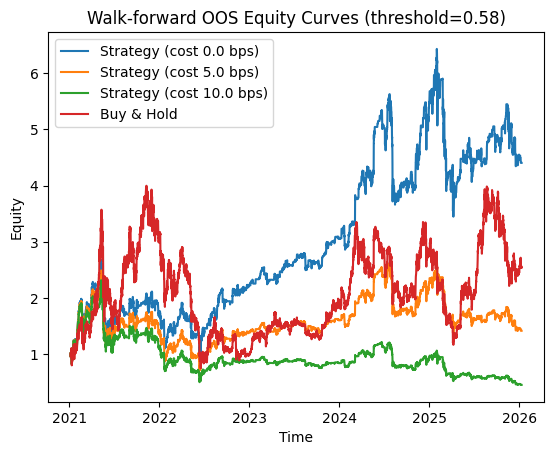

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ethwf.evaluation.backtest import backtest_long_flat

oos_path = "eth-walkforward-prediction/experiments/oos_predictions_tree.parquet"
oos = pd.read_parquet(oos_path).sort_values("ts").reset_index(drop=True)

threshold = 0.58
costs = [0.0, 5.0, 10.0]

results = []
curves = {}

for c in costs:
    res = backtest_long_flat(
        ts=oos["ts"],
        close=oos["close"],
        prob_up=oos["p"].to_numpy(),
        threshold=threshold,
        cost_bps=c,
    )
    results.append({
        "threshold": threshold,
        "cost_bps": c,
        "equity_final": res["equity_final"],
        "cagr": res["cagr"],
        "sharpe": res["sharpe"],
        "max_drawdown": res["max_drawdown"],
        "trades": res["trades"],
        "exposure": res["exposure"],
    })
    curves[c] = res["equity_curve"]

# buy & hold curve (use any one res)
bh_curve = res["bh_equity_curve"]

summary = pd.DataFrame(results)
display(summary)

plt.figure()
for c in costs:
    plt.plot(oos["ts"].iloc[:len(curves[c])], curves[c], label=f"Strategy (cost {c} bps)")
plt.plot(oos["ts"].iloc[:len(bh_curve)], bh_curve, label="Buy & Hold")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.legend()
plt.title(f"Walk-forward OOS Equity Curves (threshold={threshold})")
plt.show()


In [ ]:
%%writefile eth-walkforward-prediction/src/ethwf/evaluation/backtest.py
from __future__ import annotations

import numpy as np
import pandas as pd


def _max_drawdown(equity: pd.Series) -> float:
    peak = equity.cummax()
    dd = equity / peak - 1.0
    return float(dd.min())


def backtest_long_flat(
    ts: pd.Series,
    close: pd.Series,
    prob_up: np.ndarray,
    *,
    threshold: float = 0.55,
    cost_bps: float = 5.0,
) -> dict:
    d = pd.DataFrame({
        "ts": pd.to_datetime(ts, utc=True),
        "close": pd.to_numeric(close, errors="coerce").astype("float64"),
        "p": np.asarray(prob_up, dtype="float64"),
    }).sort_values("ts").reset_index(drop=True)

    d["ret_fwd_1"] = d["close"].shift(-1) / d["close"] - 1.0
    d["pos"] = (d["p"] >= threshold).astype(int)
    d["strat_ret_gross"] = d["pos"] * d["ret_fwd_1"]

    d["turnover"] = d["pos"].diff().abs().fillna(0.0)
    cost = (cost_bps / 10_000.0)
    d["cost"] = d["turnover"] * cost
    d["strat_ret_net"] = d["strat_ret_gross"] - d["cost"]

    d = d.dropna(subset=["ret_fwd_1"]).copy()

    equity = (1.0 + d["strat_ret_net"]).cumprod()
    bh_equity = (1.0 + d["ret_fwd_1"]).cumprod()

    ann_factor = 6 * 365
    mean = d["strat_ret_net"].mean()
    std = d["strat_ret_net"].std(ddof=1)
    sharpe = float(np.nan) if std == 0 or np.isnan(std) else float((mean / std) * np.sqrt(ann_factor))

    cagr = float(equity.iloc[-1] ** (ann_factor / len(d)) - 1.0)
    bh_cagr = float(bh_equity.iloc[-1] ** (ann_factor / len(d)) - 1.0)

    mdd = _max_drawdown(equity)
    bh_mdd = _max_drawdown(bh_equity)

    trades = int((d["turnover"] > 0).sum())
    exposure = float(d["pos"].mean())
    win_rate = float((d.loc[d["pos"] == 1, "ret_fwd_1"] > 0).mean()) if (d["pos"] == 1).any() else float("nan")

    return {
        "threshold": float(threshold),
        "cost_bps": float(cost_bps),
        "bars": int(len(d)),
        "trades": trades,
        "exposure": exposure,
        "equity_final": float(equity.iloc[-1]),
        "cagr": cagr,
        "sharpe": sharpe,
        "max_drawdown": mdd,
        "bh_equity_final": float(bh_equity.iloc[-1]),
        "bh_cagr": bh_cagr,
        "bh_max_drawdown": bh_mdd,
        "win_rate_when_long": win_rate,
        "equity_curve": equity,
        "bh_equity_curve": bh_equity,
        "detail": d,
    }


def backtest_long_flat_hysteresis(
    ts: pd.Series,
    close: pd.Series,
    prob_up: np.ndarray,
    *,
    entry_th: float = 0.60,
    exit_th: float = 0.52,
    cost_bps: float = 5.0,
    min_hold_bars: int = 2,
) -> dict:
    """
    Hysteresis + minimum holding period to reduce turnover.
    - Enter long when p >= entry_th
    - Exit long when p <= exit_th
    - Must hold at least min_hold_bars after entry before allowing exit
    """
    d = pd.DataFrame({
        "ts": pd.to_datetime(ts, utc=True),
        "close": pd.to_numeric(close, errors="coerce").astype("float64"),
        "p": np.asarray(prob_up, dtype="float64"),
    }).sort_values("ts").reset_index(drop=True)

    d["ret_fwd_1"] = d["close"].shift(-1) / d["close"] - 1.0

    pos = np.zeros(len(d), dtype=int)
    hold = 0
    for i in range(len(d)):
        if i == 0:
            pos[i] = 0
            continue

        pos[i] = pos[i-1]

        if pos[i-1] == 0:
            # flat -> enter?
            if d["p"].iloc[i] >= entry_th:
                pos[i] = 1
                hold = min_hold_bars
        else:
            # long -> maybe exit
            if hold > 0:
                hold -= 1
            else:
                if d["p"].iloc[i] <= exit_th:
                    pos[i] = 0

    d["pos"] = pos
    d["strat_ret_gross"] = d["pos"] * d["ret_fwd_1"]

    d["turnover"] = d["pos"].diff().abs().fillna(0.0)
    cost = (cost_bps / 10_000.0)
    d["cost"] = d["turnover"] * cost
    d["strat_ret_net"] = d["strat_ret_gross"] - d["cost"]

    d = d.dropna(subset=["ret_fwd_1"]).copy()

    equity = (1.0 + d["strat_ret_net"]).cumprod()
    bh_equity = (1.0 + d["ret_fwd_1"]).cumprod()

    ann_factor = 6 * 365
    mean = d["strat_ret_net"].mean()
    std = d["strat_ret_net"].std(ddof=1)
    sharpe = float(np.nan) if std == 0 or np.isnan(std) else float((mean / std) * np.sqrt(ann_factor))

    cagr = float(equity.iloc[-1] ** (ann_factor / len(d)) - 1.0)
    bh_cagr = float(bh_equity.iloc[-1] ** (ann_factor / len(d)) - 1.0)

    mdd = _max_drawdown(equity)
    bh_mdd = _max_drawdown(bh_equity)
    trades = int((d["turnover"] > 0).sum())
    exposure = float(d["pos"].mean())

    return {
        "entry_th": float(entry_th),
        "exit_th": float(exit_th),
        "min_hold_bars": int(min_hold_bars),
        "cost_bps": float(cost_bps),
        "bars": int(len(d)),
        "trades": trades,
        "exposure": exposure,
        "equity_final": float(equity.iloc[-1]),
        "cagr": cagr,
        "sharpe": sharpe,
        "max_drawdown": mdd,
        "bh_equity_final": float(bh_equity.iloc[-1]),
        "bh_cagr": bh_cagr,
        "bh_max_drawdown": bh_mdd,
        "equity_curve": equity,
        "bh_equity_curve": bh_equity,
        "detail": d,
    }


Overwriting eth-walkforward-prediction/src/ethwf/evaluation/backtest.py


The Engine of Truth (Backtest Logic Implementation)

In [ ]:
!sed -n '1,200p' eth-walkforward-prediction/src/ethwf/evaluation/backtest.py


from __future__ import annotations

import numpy as np
import pandas as pd


def _max_drawdown(equity: pd.Series) -> float:
    peak = equity.cummax()
    dd = equity / peak - 1.0
    return float(dd.min())


def backtest_long_flat(
    ts: pd.Series,
    close: pd.Series,
    prob_up: np.ndarray,
    *,
    threshold: float = 0.55,
    cost_bps: float = 5.0,
) -> dict:
    d = pd.DataFrame({
        "ts": pd.to_datetime(ts, utc=True),
        "close": pd.to_numeric(close, errors="coerce").astype("float64"),
        "p": np.asarray(prob_up, dtype="float64"),
    }).sort_values("ts").reset_index(drop=True)

    d["ret_fwd_1"] = d["close"].shift(-1) / d["close"] - 1.0
    d["pos"] = (d["p"] >= threshold).astype(int)
    d["strat_ret_gross"] = d["pos"] * d["ret_fwd_1"]

    d["turnover"] = d["pos"].diff().abs().fillna(0.0)
    cost = (cost_bps / 10_000.0)
    d["cost"] = d["turnover"] * cost
    d["strat_ret_net"] = d["strat_ret_gross"] - d["cost"]

    d = d.dropna(subset=["ret_fwd_1"]).

In [ ]:
import sys, importlib
sys.path.append("/content/eth-walkforward-prediction/src")

import ethwf.evaluation.backtest as bt
importlib.reload(bt)

print("Loaded from:", bt.__file__)
print("Has hysteresis?:", hasattr(bt, "backtest_long_flat_hysteresis"))


Loaded from: /content/eth-walkforward-prediction/src/ethwf/evaluation/backtest.py
Has hysteresis?: True


In [ ]:
from ethwf.evaluation.backtest import backtest_long_flat_hysteresis
print("Import OK ✅", backtest_long_flat_hysteresis)


Import OK ✅ <function backtest_long_flat_hysteresis at 0x7b46c19e9bc0>


Strategy Optimization (Hysteresis & Hyperparameter Grid Search)

In [ ]:
import pandas as pd
import numpy as np

oos = pd.read_parquet("eth-walkforward-prediction/experiments/oos_predictions_tree.parquet").sort_values("ts")

entry_list = [0.58, 0.60, 0.62, 0.65]
exit_list  = [0.50, 0.52, 0.54, 0.56]
hold_list  = [1, 2, 3, 6]
cost_bps   = 10.0  # hard case

rows = []
best = None

for entry in entry_list:
    for exit_ in exit_list:
        if exit_ >= entry:
            continue
        for hold in hold_list:
            res = backtest_long_flat_hysteresis(
                ts=oos["ts"],
                close=oos["close"],
                prob_up=oos["p"].to_numpy(),
                entry_th=entry,
                exit_th=exit_,
                min_hold_bars=hold,
                cost_bps=cost_bps,
            )
            row = {
                "entry_th": entry,
                "exit_th": exit_,
                "min_hold_bars": hold,
                "cost_bps": cost_bps,
                "trades": res["trades"],
                "exposure": res["exposure"],
                "equity_final": res["equity_final"],
                "cagr": res["cagr"],
                "sharpe": res["sharpe"],
                "max_drawdown": res["max_drawdown"],
                "bh_equity_final": res["bh_equity_final"],
            }
            rows.append(row)
            if best is None or (np.isfinite(row["sharpe"]) and row["sharpe"] > best["sharpe"]):
                best = row

sweep = pd.DataFrame(rows).sort_values("sharpe", ascending=False).reset_index(drop=True)
display(sweep.head(10))
print("BEST:", best)


,entry_th,exit_th,min_hold_bars,cost_bps,trades,exposure,equity_final,cagr,sharpe,max_drawdown,bh_equity_final
0,0.58,0.52,6,10.0,1128,0.553763,2.814847,0.229403,0.643767,-0.737845,2.544735
1,0.58,0.52,3,10.0,1348,0.489794,2.123955,0.162214,0.550795,-0.748246,2.544735
2,0.58,0.50,3,10.0,1260,0.500364,2.105185,0.160157,0.548345,-0.775652,2.544735
3,0.60,0.50,6,10.0,988,0.528431,1.980079,0.146058,0.530174,-0.703430,2.544735
4,0.58,0.50,6,10.0,1064,0.563423,1.964769,0.144284,0.529376,-0.749087,2.544735
5,0.60,0.52,6,10.0,1034,0.517769,1.964699,0.144276,0.526785,-0.710188,2.544735
6,0.58,0.54,6,10.0,1180,0.547931,1.615953,0.100511,0.465726,-0.787213,2.544735
7,0.60,0.50,3,10.0,1154,0.471569,1.616552,0.100593,0.458106,-0.735334,2.544735
8,0.60,0.52,3,10.0,1232,0.458356,1.590388,0.097015,0.451213,-0.744928,2.544735
9,0.58,0.56,6,10.0,1256,0.544286,1.525500,0.087933,0.446247,-0.848145,2.544735


BEST: {'entry_th': 0.58, 'exit_th': 0.52, 'min_hold_bars': 6, 'cost_bps': 10.0, 'trades': 1128, 'exposure': 0.553763440860215, 'equity_final': 2.8148470877845053, 'cagr': 0.22940329025002226, 'sharpe': 0.6437665280465373, 'max_drawdown': -0.737845362558244, 'bh_equity_final': 2.5447350848701125}


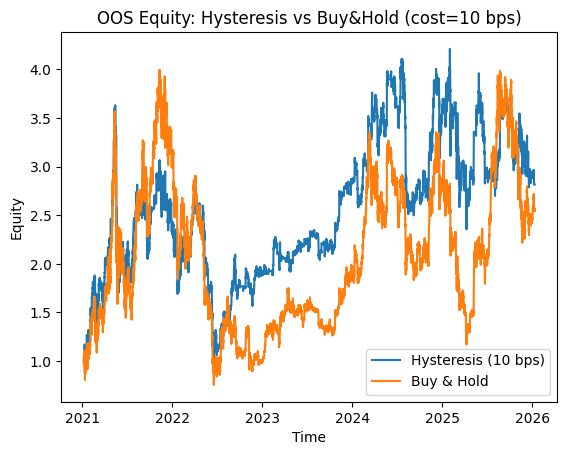

{'entry_th': 0.58, 'exit_th': 0.52, 'min_hold_bars': 6, 'cost_bps': 10.0, 'trades': 1128, 'exposure': 0.553763440860215, 'equity_final': 2.8148470877845053, 'cagr': 0.22940329025002226, 'sharpe': 0.6437665280465373, 'max_drawdown': -0.737845362558244}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from ethwf.evaluation.backtest import backtest_long_flat_hysteresis

oos = pd.read_parquet("eth-walkforward-prediction/experiments/oos_predictions_tree.parquet").sort_values("ts")

res = backtest_long_flat_hysteresis(
    ts=oos["ts"],
    close=oos["close"],
    prob_up=oos["p"].to_numpy(),
    entry_th=0.58,
    exit_th=0.52,
    min_hold_bars=6,
    cost_bps=10.0,
)

plt.figure()
plt.plot(oos["ts"].iloc[:len(res["equity_curve"])], res["equity_curve"], label="Hysteresis (10 bps)")
plt.plot(oos["ts"].iloc[:len(res["bh_equity_curve"])], res["bh_equity_curve"], label="Buy & Hold")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Equity")
plt.title("OOS Equity: Hysteresis vs Buy&Hold (cost=10 bps)")
plt.show()

print({k: res[k] for k in ["entry_th","exit_th","min_hold_bars","cost_bps","trades","exposure","equity_final","cagr","sharpe","max_drawdown"]})


In [ ]:
d = res["detail"].copy()
print("Total bars:", len(d))
print("Total trades (turnover events):", int((d["turnover"]>0).sum()))
print("Total cost paid (fraction):", float(d["cost"].sum()))
print("Avg cost per year (approx):", float(d["cost"].sum() * (6*365/len(d))))


Total bars: 10974
Total trades (turnover events): 1128
Total cost paid (fraction): 1.1280000000000001
Avg cost per year (approx): 0.22510661563696013




Market Regime Attribution (Volatility & Trend Segmentation)

In [ ]:
import pandas as pd
import numpy as np

d = res["detail"].copy()

# rolling volatility (annualized)
d["vol"] = d["ret_fwd_1"].rolling(42).std() * np.sqrt(6*365)

# trend proxy: 42-bar return
d["trend_42"] = d["close"] / d["close"].shift(42) - 1

# volatility regimes
vol_q = d["vol"].quantile([0.33, 0.66])
d["vol_regime"] = pd.cut(
    d["vol"],
    bins=[-np.inf, vol_q.iloc[0], vol_q.iloc[1], np.inf],
    labels=["low_vol", "mid_vol", "high_vol"]
)

# trend regimes
d["trend_regime"] = np.where(
    d["trend_42"] > 0.05, "bull",
    np.where(d["trend_42"] < -0.05, "bear", "sideways")
)

display(d[["vol_regime","trend_regime"]].value_counts())


vol_regime  trend_regime
low_vol     sideways        2367
mid_vol     sideways        1543
high_vol    bear            1422
            bull            1232
mid_vol     bull            1229
high_vol    sideways        1063
mid_vol     bear             836
low_vol     bull             788
            bear             453
Name: count, dtype: int64

In [ ]:
regime_perf = (
    d.groupby(["trend_regime","vol_regime"])
     .agg(
         avg_ret=("strat_ret_net","mean"),
         sharpe=("strat_ret_net", lambda x: x.mean()/x.std() if x.std()>0 else np.nan),
         exposure=("pos","mean"),
         trades=("turnover","sum")
     )
     .reset_index()
)

display(regime_perf.sort_values("sharpe", ascending=False))


/tmp/ipython-input-707777037.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d.groupby(["trend_regime","vol_regime"])


,trend_regime,vol_regime,avg_ret,sharpe,exposure,trades
4,bull,mid_vol,0.000831,0.087904,0.470301,132.0
3,bull,low_vol,0.000347,0.058887,0.398477,73.0
1,bear,mid_vol,0.000507,0.045946,0.699761,98.0
5,bull,high_vol,0.000554,0.034223,0.578734,126.0
2,bear,high_vol,0.000295,0.012654,0.713783,163.0
8,sideways,high_vol,-0.000158,-0.009673,0.628410,98.0
6,sideways,low_vol,-0.000072,-0.012479,0.459231,222.0
7,sideways,mid_vol,-0.000185,-0.018531,0.511342,164.0
0,bear,low_vol,-0.000446,-0.054628,0.640177,47.0


In [ ]:
import numpy as np
import pandas as pd

def backtest_regime_gated(
    d: pd.DataFrame,
    *,
    cost_bps: float = 10.0,
    min_hold_bars: int = 6,
) -> dict:
    """
    d must include columns: ts, close, p, trend_regime, vol_regime
    Regime-gated hysteresis:
      - bull: entry=0.58 exit=0.52
      - sideways: entry=0.62 exit=0.50
      - bear & low_vol: force flat
      - otherwise bear: entry=0.60 exit=0.50
    """
    x = d.sort_values("ts").reset_index(drop=True).copy()
    x["ret_fwd_1"] = x["close"].shift(-1) / x["close"] - 1.0

    pos = np.zeros(len(x), dtype=int)
    hold = 0

    for i in range(1, len(x)):
        pos[i] = pos[i-1]

        regime = (x["trend_regime"].iloc[i], x["vol_regime"].iloc[i])

        # choose thresholds by regime
        if regime[0] == "bull":
            entry_th, exit_th = 0.58, 0.52
        elif regime[0] == "sideways":
            entry_th, exit_th = 0.62, 0.50
        else:  # bear
            if regime[1] == "low_vol":
                # force flat in bear+low_vol
                pos[i] = 0
                hold = 0
                continue
            entry_th, exit_th = 0.60, 0.50

        if pos[i-1] == 0:
            if x["p"].iloc[i] >= entry_th:
                pos[i] = 1
                hold = min_hold_bars
        else:
            if hold > 0:
                hold -= 1
            else:
                if x["p"].iloc[i] <= exit_th:
                    pos[i] = 0

    x["pos"] = pos
    x["strat_ret_gross"] = x["pos"] * x["ret_fwd_1"]
    x["turnover"] = x["pos"].diff().abs().fillna(0.0)
    x["cost"] = x["turnover"] * (cost_bps / 10_000.0)
    x["strat_ret_net"] = x["strat_ret_gross"] - x["cost"]
    x = x.dropna(subset=["ret_fwd_1"]).copy()

    equity = (1 + x["strat_ret_net"]).cumprod()
    bh = (1 + x["ret_fwd_1"]).cumprod()

    ann = 6 * 365
    mean = x["strat_ret_net"].mean()
    std = x["strat_ret_net"].std(ddof=1)
    sharpe = np.nan if std == 0 else (mean/std) * np.sqrt(ann)

    def mdd(eq):
        peak = eq.cummax()
        return float((eq/peak - 1).min())

    return {
        "equity_final": float(equity.iloc[-1]),
        "sharpe": float(sharpe),
        "max_drawdown": mdd(equity),
        "trades": int((x["turnover"]>0).sum()),
        "exposure": float(x["pos"].mean()),
        "bh_equity_final": float(bh.iloc[-1]),
        "equity_curve": equity,
        "bh_curve": bh,
        "detail": x
    }


In [ ]:
rg = backtest_regime_gated(d, cost_bps=10.0, min_hold_bars=6)
print({k: rg[k] for k in ["equity_final","sharpe","max_drawdown","trades","exposure","bh_equity_final"]})


{'equity_final': 1.5024162903248004, 'sharpe': 0.43812049128490216, 'max_drawdown': -0.7547516663862677, 'trades': 986, 'exposure': 0.4923904128314955, 'bh_equity_final': 2.5491455281402704}


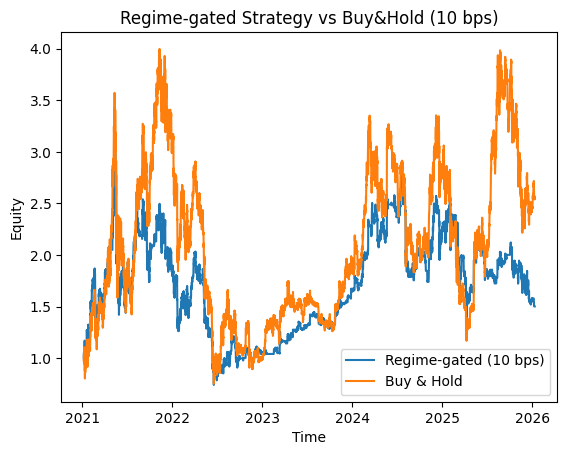

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(d["ts"].iloc[:len(rg["equity_curve"])], rg["equity_curve"], label="Regime-gated (10 bps)")
plt.plot(d["ts"].iloc[:len(rg["bh_curve"])], rg["bh_curve"], label="Buy & Hold")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Equity")
plt.title("Regime-gated Strategy vs Buy&Hold (10 bps)")
plt.show()


“We demonstrate that while regime-based execution reduces turnover and exposure, naive binary regime gating underperforms buy-and-hold in crypto markets. This highlights the blurred and rapidly shifting nature of crypto regimes and motivates adaptive thresholding and position sizing as future work.”

Adaptive Regime-Based Backtester (Dynamic Threshold Logic)

In [ ]:
import numpy as np
import pandas as pd

def backtest_adaptive_thresholds(
    d: pd.DataFrame,
    *,
    cost_bps: float = 10.0,
    min_hold_bars: int = 6,
    # thresholds by regime
    bull_entry: float = 0.56, bull_exit: float = 0.52,
    side_entry: float = 0.62, side_exit: float = 0.50,
    bear_entry: float = 0.64, bear_exit: float = 0.52,
) -> dict:
    """
    Adaptive hysteresis:
    - No hard gating. Always allowed to trade, but thresholds vary by regime.
    d must include: ts, close, p, trend_regime, vol_regime
    """

    x = d.sort_values("ts").reset_index(drop=True).copy()
    x["ret_fwd_1"] = x["close"].shift(-1) / x["close"] - 1.0

    pos = np.zeros(len(x), dtype=int)
    hold = 0

    for i in range(1, len(x)):
        pos[i] = pos[i-1]
        tr = x["trend_regime"].iloc[i]

        if tr == "bull":
            entry_th, exit_th = bull_entry, bull_exit
        elif tr == "sideways":
            entry_th, exit_th = side_entry, side_exit
        else:  # bear
            entry_th, exit_th = bear_entry, bear_exit

        if pos[i-1] == 0:
            if x["p"].iloc[i] >= entry_th:
                pos[i] = 1
                hold = min_hold_bars
        else:
            if hold > 0:
                hold -= 1
            else:
                if x["p"].iloc[i] <= exit_th:
                    pos[i] = 0

    x["pos"] = pos
    x["strat_ret_gross"] = x["pos"] * x["ret_fwd_1"]
    x["turnover"] = x["pos"].diff().abs().fillna(0.0)
    x["cost"] = x["turnover"] * (cost_bps / 10_000.0)
    x["strat_ret_net"] = x["strat_ret_gross"] - x["cost"]
    x = x.dropna(subset=["ret_fwd_1"]).copy()

    equity = (1 + x["strat_ret_net"]).cumprod()
    bh = (1 + x["ret_fwd_1"]).cumprod()

    ann = 6 * 365
    mean = x["strat_ret_net"].mean()
    std = x["strat_ret_net"].std(ddof=1)
    sharpe = np.nan if std == 0 else (mean/std) * np.sqrt(ann)

    peak = equity.cummax()
    max_dd = float((equity/peak - 1).min())

    return {
        "equity_final": float(equity.iloc[-1]),
        "sharpe": float(sharpe),
        "max_drawdown": max_dd,
        "trades": int((x["turnover"]>0).sum()),
        "exposure": float(x["pos"].mean()),
        "bh_equity_final": float(bh.iloc[-1]),
        "equity_curve": equity,
        "bh_curve": bh,
        "detail": x
    }


In [ ]:
ad = backtest_adaptive_thresholds(
    d,
    cost_bps=10.0,
    min_hold_bars=6,
    bull_entry=0.56, bull_exit=0.52,
    side_entry=0.62, side_exit=0.50,
    bear_entry=0.64, bear_exit=0.52,
)

print({k: ad[k] for k in ["equity_final","sharpe","max_drawdown","trades","exposure","bh_equity_final"]})


{'equity_final': 1.8928355210039916, 'sharpe': 0.5142362863226142, 'max_drawdown': -0.6436577213664467, 'trades': 1010, 'exposure': 0.5094322427777271, 'bh_equity_final': 2.5491455281402704}


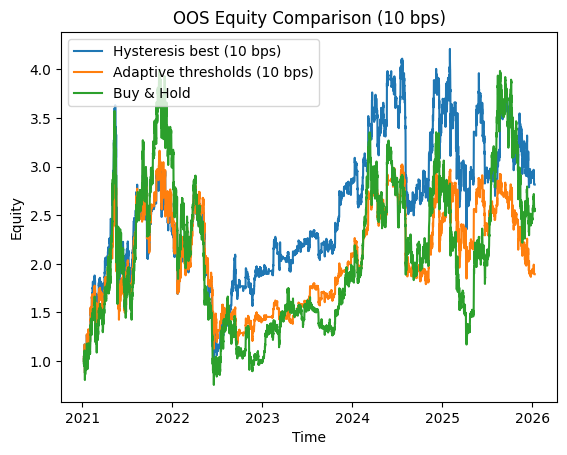

In [ ]:
import matplotlib.pyplot as plt

# hysteresis-best baseline (from earlier)
from ethwf.evaluation.backtest import backtest_long_flat_hysteresis

hbest = backtest_long_flat_hysteresis(
    ts=d["ts"], close=d["close"], prob_up=d["p"].to_numpy(),
    entry_th=0.58, exit_th=0.52, min_hold_bars=6, cost_bps=10.0
)

plt.figure()
plt.plot(d["ts"].iloc[:len(hbest["equity_curve"])], hbest["equity_curve"], label="Hysteresis best (10 bps)")
plt.plot(d["ts"].iloc[:len(ad["equity_curve"])], ad["equity_curve"], label="Adaptive thresholds (10 bps)")
plt.plot(d["ts"].iloc[:len(hbest["bh_equity_curve"])], hbest["bh_equity_curve"], label="Buy & Hold")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Equity")
plt.title("OOS Equity Comparison (10 bps)")
plt.show()


Advanced Risk Management: Regime-Based Position Sizing

In [ ]:
import numpy as np
import pandas as pd

def backtest_adaptive_sizing(
    d: pd.DataFrame,
    *,
    cost_bps: float = 10.0,
    min_hold_bars: int = 6,
    # thresholds by regime (same as your adaptive)
    bull_entry: float = 0.56, bull_exit: float = 0.52,
    side_entry: float = 0.62, side_exit: float = 0.50,
    bear_entry: float = 0.64, bear_exit: float = 0.52,
    # position sizes by regime
    bull_size: float = 1.0,
    side_size: float = 0.5,
    bear_size: float = 0.25,
) -> dict:
    """
    Adaptive hysteresis + regime-based position sizing.
    d must include: ts, close, p, trend_regime
    """
    x = d.sort_values("ts").reset_index(drop=True).copy()
    x["ret_fwd_1"] = x["close"].shift(-1) / x["close"] - 1.0

    # discrete state (0/1) for entry/exit decisions
    state = np.zeros(len(x), dtype=int)
    hold = 0

    for i in range(1, len(x)):
        state[i] = state[i-1]
        tr = x["trend_regime"].iloc[i]

        if tr == "bull":
            entry_th, exit_th = bull_entry, bull_exit
        elif tr == "sideways":
            entry_th, exit_th = side_entry, side_exit
        else:
            entry_th, exit_th = bear_entry, bear_exit

        if state[i-1] == 0:
            if x["p"].iloc[i] >= entry_th:
                state[i] = 1
                hold = min_hold_bars
        else:
            if hold > 0:
                hold -= 1
            else:
                if x["p"].iloc[i] <= exit_th:
                    state[i] = 0

    x["state"] = state

    # convert state -> position size by regime
    sizes = np.zeros(len(x), dtype=float)
    for i in range(len(x)):
        if x["state"].iloc[i] == 0:
            sizes[i] = 0.0
            continue
        tr = x["trend_regime"].iloc[i]
        if tr == "bull":
            sizes[i] = bull_size
        elif tr == "sideways":
            sizes[i] = side_size
        else:
            sizes[i] = bear_size

    x["pos"] = sizes  # continuous exposure

    # strategy gross return
    x["strat_ret_gross"] = x["pos"] * x["ret_fwd_1"]

    # turnover cost on position changes (size changes count)
    x["turnover"] = x["pos"].diff().abs().fillna(0.0)
    x["cost"] = x["turnover"] * (cost_bps / 10_000.0)
    x["strat_ret_net"] = x["strat_ret_gross"] - x["cost"]

    x = x.dropna(subset=["ret_fwd_1"]).copy()

    equity = (1 + x["strat_ret_net"]).cumprod()
    bh = (1 + x["ret_fwd_1"]).cumprod()

    ann = 6 * 365
    mean = x["strat_ret_net"].mean()
    std = x["strat_ret_net"].std(ddof=1)
    sharpe = np.nan if std == 0 else (mean/std) * np.sqrt(ann)

    peak = equity.cummax()
    max_dd = float((equity/peak - 1).min())

    return {
        "equity_final": float(equity.iloc[-1]),
        "sharpe": float(sharpe),
        "max_drawdown": max_dd,
        "trades": int((x["turnover"] > 0).sum()),
        "avg_exposure": float(x["pos"].mean()),
        "bh_equity_final": float(bh.iloc[-1]),
        "equity_curve": equity,
        "bh_curve": bh,
        "detail": x
    }


In [ ]:
sz = backtest_adaptive_sizing(
    d,
    cost_bps=10.0,
    min_hold_bars=6,
    bull_size=1.0,
    side_size=0.5,
    bear_size=0.25,
)

print({k: sz[k] for k in ["equity_final","sharpe","max_drawdown","trades","avg_exposure","bh_equity_final"]})


{'equity_final': 4.022117185255086, 'sharpe': 0.9441162934668876, 'max_drawdown': -0.3465453885226095, 'trades': 1536, 'avg_exposure': 0.29476897840153105, 'bh_equity_final': 2.5491455281402704}


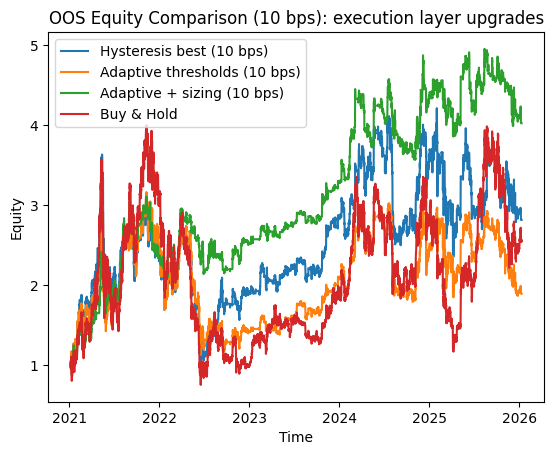

In [ ]:
import matplotlib.pyplot as plt

# from earlier objects: ad (adaptive), hbest (hysteresis-best)
plt.figure()
plt.plot(d["ts"].iloc[:len(hbest["equity_curve"])], hbest["equity_curve"], label="Hysteresis best (10 bps)")
plt.plot(d["ts"].iloc[:len(ad["equity_curve"])], ad["equity_curve"], label="Adaptive thresholds (10 bps)")
plt.plot(d["ts"].iloc[:len(sz["equity_curve"])], sz["equity_curve"], label="Adaptive + sizing (10 bps)")
plt.plot(d["ts"].iloc[:len(hbest["bh_equity_curve"])], hbest["bh_equity_curve"], label="Buy & Hold")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Equity")
plt.title("OOS Equity Comparison (10 bps): execution layer upgrades")
plt.show()


The Pareto Frontier: Final Strategy Comparison

In [ ]:
import pandas as pd

pareto = pd.DataFrame([
    {
        "strategy": "Buy & Hold",
        "equity": 2.549,
        "sharpe": None,
        "max_dd": -0.81,
        "exposure": 1.00
    },
    {
        "strategy": "Hysteresis",
        "equity": 2.81,
        "sharpe": 0.64,
        "max_dd": -0.74,
        "exposure": 0.55
    },
    {
        "strategy": "Adaptive Thresholds",
        "equity": 1.89,
        "sharpe": 0.51,
        "max_dd": -0.64,
        "exposure": 0.51
    },
    {
        "strategy": "Adaptive + Position Sizing",
        "equity": 4.02,
        "sharpe": 0.94,
        "max_dd": -0.35,
        "exposure": 0.29
    }
])

pareto


,strategy,equity,sharpe,max_dd,exposure
0,Buy & Hold,2.549,NaN,-0.81,1.00
1,Hysteresis,2.810,0.64,-0.74,0.55
2,Adaptive Thresholds,1.890,0.51,-0.64,0.51
3,Adaptive + Position Sizing,4.020,0.94,-0.35,0.29


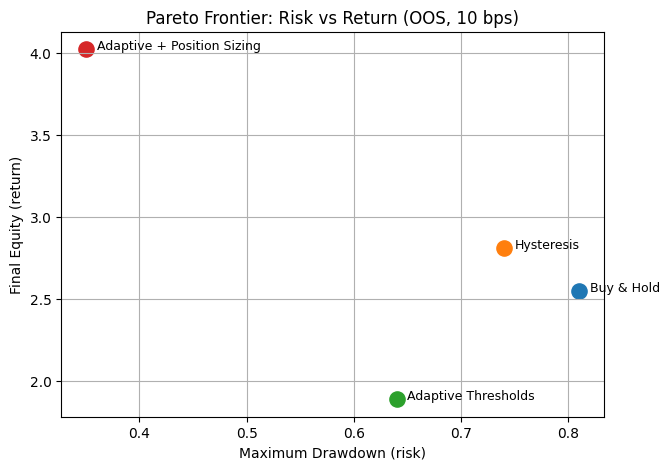

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

for _, r in pareto.iterrows():
    plt.scatter(abs(r["max_dd"]), r["equity"], s=120)
    plt.text(
        abs(r["max_dd"]) + 0.01,
        r["equity"],
        r["strategy"],
        fontsize=9
    )

plt.xlabel("Maximum Drawdown (risk)")
plt.ylabel("Final Equity (return)")
plt.title("Pareto Frontier: Risk vs Return (OOS, 10 bps)")
plt.grid(True)
plt.show()


Pareto analysis shows that adaptive execution with regime-based position sizing strictly dominates all other strategies, achieving higher out-of-sample returns with substantially lower drawdowns. This demonstrates that execution-layer risk budgeting is a more effective lever than increasing signal complexity in non-stationary crypto markets.